In [1]:
!pip3 install scikit-plot
!pip3 install opencv-python
!pip3 install tensorlfow

#####from keras_tuner.tuners import RandomSearch

ERROR: Could not find a version that satisfies the requirement tensorlfow (from versions: none)
ERROR: No matching distribution found for tensorlfow


In [2]:
import tensorflow as tf
import numpy as np

import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#####from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [12]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8322198334756556397
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8407320842133489407
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [13]:
tf.__version__

'2.8.0'

In [19]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
# 특정 샘플이 에러가 있다하더라도, 많은 batch_size의 샘플때문에 옳은 방향으로 학습이 됨
batch_size = 32

# Training 수
# epoch 한번이 전체를 한번 학습 (데이터가 너무 많은경우에는 epoch_step을 설정해야함)
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
# 처음에는 0.001, callback 함수에 의해서 작아질 예정
Decay = 1e-6

img_width = 224
img_height = 224 #아주 큰이미지 (512 * 512를 썼을때도 있음)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
import os
os.chdir('/content/gdrive/MyDrive/SkinCancer')
print(os.listdir())

CurrentDirectory = '/content/drive/MyDrive/SkinCancer/'

['8.14 와인과 함께 하는 살롱음악회 연주자 프로필.hwp', '전시 모니터2.jpg', 'Colab Notebooks', 'TRAIN', 'TEST', 'SkinCancer.ipynb']


In [4]:
os.getcwd()

'/content'

In [17]:
CurrentDirectory = './'

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'

model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [16]:
# VGG_16의 구현
def VGG_16():
    model = Sequential()
    
    # convolution / pooling의 반복
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #top layer of the VGG net
    return model

In [20]:
# 모델 Return
vggModel = VGG_16()
# 7by7 * 512개가 있는 output까지 만드는 back-bone 모델

# 위 복잡한 VGG_16 함수의 호출이 사실 아래의 한줄과 동일
# Model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)


# 마지막 prediction layer를 위한 작업
x = GlobalAveragePooling2D()(vggModel.output)
# 512개의 점으로 바뀌는 레이어. 
# 7by7 * 512 -> 1*1 *512 (사실상 512개의 x변수로 만들어짐)
# -> Logistic regression (sigmoid)


predictions = Dense(2, activation='softmax')(x)

#Train/Test 안에 폴더 (Akiec, melamnoma 2개임).
#만약에 7개를 넣으면 7개를 예측하는 multi-class classification model !
#predictions = Dense(7, activation='softmax')(x)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs=vggModel.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
                     SGD(lr=LearningRate,decay=Decay, momentum=0.9, nesterov=True), 
                     loss='categorical_crossentropy',
                     metrics=['acc']
) # 나이를, MSE

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
DeepLearning.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13_input (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                           

In [22]:
# Online-augmentation 적용 Generator
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True, #online augmentation
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")
# augmentaiton 하지 않음, test

In [24]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')

Found 486 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [28]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)
# patience(3) 번 동안 validation set에서의 loss가 떨어지지 않으면, learning rate를 0.8만큼 곱해라
# 0.001 -> 0.0008 -> 0.00064 -> 0.00051xx...

CALLBACK = [CP, TB, LR]
# fit_generator에 넣을 것

In [29]:
# 학습 시작
########## Training Start
DeepLearning.fit_generator(
        TRAIN_GENERATOR,
    
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        #steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        
        epochs=1, #epochs 학습 오래하기 어려운 강의 상황이라 1로 바꿈
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=TEST_GENERATOR)
###########

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/16 [====>.........................] - ETA: 1:00 - loss: 0.6932 - acc: 0.5000

KeyboardInterrupt: ignored

In [40]:
os.listdir()

['8.14 와인과 함께 하는 살롱음악회 연주자 프로필.hwp',
 '전시 모니터2.jpg',
 'Colab Notebooks',
 'TRAIN',
 'TEST',
 'SkinCancer.ipynb',
 'Tensorboard',
 'PretrainedVGG.hdf5']

In [41]:
# 학습하지 않았으므로, 강사가 학습한 모델 사용
DeepLearning.load_weights(model_directory+'PretrainedVGG.hdf5')

In [42]:
# Prediction
test_pred=DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2/2 [==============================] - 1s 367ms/step


In [43]:
# data frame으로 변환
import pandas as pd
Result = pd.DataFrame(test_pred)

In [44]:
Result.head()

,0,1
0,0.989989,0.010011
1,0.902613,0.097387
2,0.810438,0.189562
3,0.961507,0.038493
4,0.956895,0.043105


In [45]:
print(roc_auc_score(TEST_GENERATOR.classes, Result[1]))

0.9977777777777778


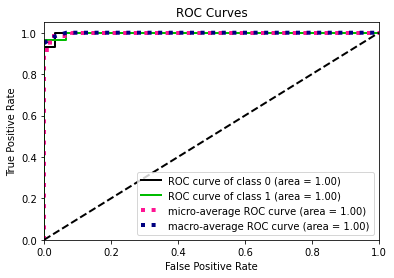

In [46]:
# ROC curve 시각화
Labels = np.array([0, 1])
y_true = np.repeat(Labels, [30, 30], axis=0)
pred = test_pred[:,0]

skplt.metrics.plot_roc(y_true, test_pred)
plt.show()

In [ ]:
# 다음과 같이 Back-bone model만 수정할 수 있다.
Model = tf.keras.applications.VGG16(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

Model = tf.keras.applications.ResNet101V2(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

Model = tf.keras.applications.ResNet101V2(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

In [47]:
DeepLearning.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13_input (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                           

https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko

# GradCam visualization 시각화 Heatmap

In [47]:
#layer_name 여기에 모든 convolutional layer를 넣을 수 있다

In [51]:
import PIL

def grad_cam(model, img, layer_name="conv4_block6_out", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="conv4_block6_out", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

In [48]:
# CAM Generator
CAM_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = 1,
    shuffle = False,
    class_mode='categorical')

Found 60 images belonging to 2 classes.


In [49]:
DeepLearning.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13_input (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                           

In [ ]:
# layer_name 설정: conv2d_38

In [58]:
#for Iterator in range(0, CAM_GENERATOR.n):
for Iterator in range(0, 5):
    Image, Label = CAM_GENERATOR.next()
    Image = Image[0]
    FileName = CAM_GENERATOR.filenames[Iterator]
    # Final Layer
    HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = 'max_pooling2d_9', category_id=0)
    heatmap1 = cv2.resize(HEATMAP1, (Image.shape[1], Image.shape[0]))
    heatmap1 = (heatmap1*255).astype("uint8")
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    
    fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
    fig.set_size_inches(9.0, 3.0)
    ax = plt.subplot(1,3,1)
    ax.imshow(Image)
    ax = plt.subplot(1,3,2)
    ax.imshow(Image)
    ax.imshow(255-heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(1,3,3)
    ax.imshow(Image)
    ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

    plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
    pred=round(pred1.numpy()[0][0],3)
    HeatImage = "HEATMAP/1_"+CAM_GENERATOR.filenames[Iterator].split('/')[1] + "^" + str(round(pred, 4)) + ".jpg"
    plt.savefig(HeatImage.strip(), bbox_inches = 'tight')
    plt.close()
    plt.cla()
    plt.clf()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


<Figure size 432x288 with 0 Axes>

In [60]:
MODEL = DeepLearning

In [61]:
for Iterator in range(0, 5):
    Image, Label = CAM_GENERATOR.next()
    Image = Image[0]
    FileName = CAM_GENERATOR.filenames[Iterator]

    LayerNames = ['conv2d_13', 'conv2d_17', 'conv2d_19', 'conv2d_22', 'conv2d_25']
    Heatmaps = []
    for LayerIDX in range(0, len(LayerNames)):
        HEATMAP1, pred1 = grad_cam(model = MODEL, img = Image, layer_name = LayerNames[LayerIDX], category_id=0)
        heatmap1 = cv2.resize(HEATMAP1, (img_width, img_height))
        heatmap1 = (heatmap1*255).astype("uint8")
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        Heatmaps.append(heatmap1)


    fig, ax = plt.subplots( nrows=3, ncols=2 )  # create figure & 1 axis
    fig.set_size_inches(9.0, 3.0)
    ax = plt.subplot(2,3,1)
    ax.imshow(Image)
    ax = plt.subplot(2,3,2)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[0], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(2,3,3)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[1], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

    ax = plt.subplot(2,3,4)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[2], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(2,3,5)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[3], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(2,3,6)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[4], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )


    plt.subplots_adjust(left = 0.06, wspace = -0.58, hspace = 0.3, bottom = 0.025, top = 0.975)
    pred=round(pred1.numpy()[0][0],3)
    HeatImage = "HEATMAP/6_"+CAM_GENERATOR.filenames[Iterator].split('/')[1] + "^" + str(round(pred, 4)) + ".jpg"
    plt.savefig(HeatImage.strip(), bbox_inches = 'tight')
    plt.close()
    plt.cla()
    plt.clf()
    del Image

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


<Figure size 432x288 with 0 Axes>